In [2]:
%reset
import os

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')

import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from colossus.cosmology import cosmology
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['theta_co'] = 0.1
sim_params_dict['theta_ej'] = 4.0
sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['M1_starcga'] = 2.5e11
sim_params_dict['epsilon_rt'] = 4.0
sim_params_dict['Mc0'] = 10**14.83
# sim_params_dict['Mc0'] = 10**1
sim_params_dict['nu_z'] = 0
sim_params_dict['nu_M'] = 0
sim_params_dict['Mstar0'] = 10**13
sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict
sim_params_dict['beam_fwhm_arcmin'] = 1.6



In [27]:
2**15

32768

In [28]:
halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 10, 64
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 2.5, 32
halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = 1e12, 1e15, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 10, 32
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**16, 512
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.25
halo_params_dict['mdef'] = '200c'




In [29]:
from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-3)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-3)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-3)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-3)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]


analysis_dict['angles_data_array'] = jnp.array(theta_data)



In [30]:
# from jax_cosmo import Cosmology
# from jax_cosmo.power import linear_matter_power
# cosmo_jax = Cosmology(
#             Omega_c=cosmo_params_dict['Om0'] - cosmo_params_dict['Ob0'],
#             Omega_b=cosmo_params_dict['Ob0'],
#             h=cosmo_params_dict['H0'] / 100.,
#             sigma8=cosmo_params_dict['sigma8'],
#             n_s=cosmo_params_dict['ns'],
#             Omega_k=0.,
#             w0=cosmo_params_dict['w0'],
#             wa=0.
#             )
# z_array = jnp.linspace(0, 1, 10)
# a_array = 1./(1. + z_array)
# k_array = jnp.logspace(-3, 1, 100)
# pkz = vmap(linear_matter_power,(None, None, 0))(cosmo_jax, k_array, a_array)



In [31]:
# # pkz.shape
# pl.figure()
# pl.plot(k_array, pkz[0,:])
# pl.plot(k_array, pkz[5,:])
# pl.xscale('log')
# pl.yscale('log')


In [32]:
# %%time
# BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


gpu


In [35]:
from get_BCMP_profile_jit import BCM_18_wP
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)


/tmp/ipykernel_1350471/2927169726.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 32/32 [00:00<00:00, 126.26it/s]
/tmp/ipykernel_1350471/2927169726.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


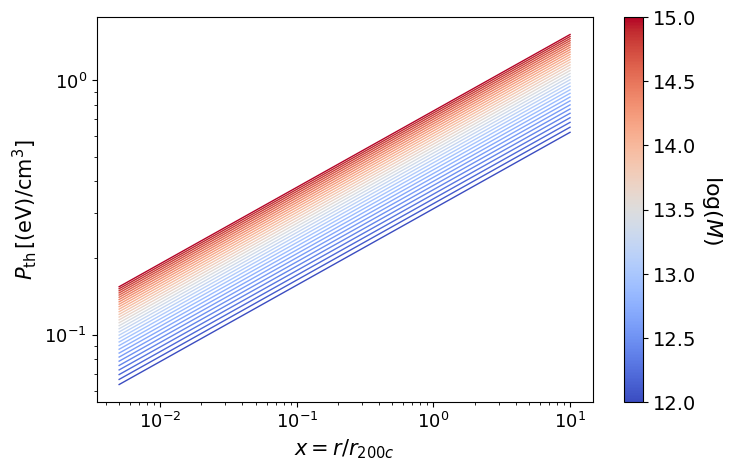

In [36]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(8,5))
Mc0_arr = np.log10(BCMP_test.M200c_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(Mc0_arr).min(), vmax=(Mc0_arr).max())

for jM in tqdm(range(len(Mc0_arr))):
    color = cmap(norm((Mc0_arr[jM])))
    # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[jM,0], BCMP_test.Pth_mat[:,4,0,jM], color=color, alpha=1.0,lw=1.0)
    pl.plot(BCMP_test.r_array, BCMP_test.Pnt_fac[:,5,0,jM], color=color, alpha=1.0,lw=1.0)
    
    
# rho3 = Battaglia_12_16(M200c, zv, cosmo)
# pl.plot(r_array/r200c, ((r_array/r200c)**2)*rho_gas_KS, label = 'KS01', ls='--', color='k',lw=2.0)
# pl.plot(r_array/r200c, rho3.fb * ((r_array/r200c)**2)*rho_gas_B16, label = 'B16', ls=':', color='k',lw=2.0)

pl.xscale('log')
pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlabel(r'$x = r/r_{200c}$', fontsize=15)
# pl.ylabel(r'$x^2 \rho_{gas}$', fontsize=15)
pl.ylabel(r'$P_{\rm th} \, [({\rm eV})/{\rm cm}^3]$', fontsize=15)
# pl.title(r'$\theta_{\rm ej} = $' + str(theta_ej) + ',' + r'$M = $' + str(np.round(np.log10(M200c), 2)), fontsize=15)
# pl.legend(fontsize=14)

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\log(M)$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






/tmp/ipykernel_1350471/137287231.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 32/32 [00:00<00:00, 126.00it/s]
/tmp/ipykernel_1350471/137287231.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


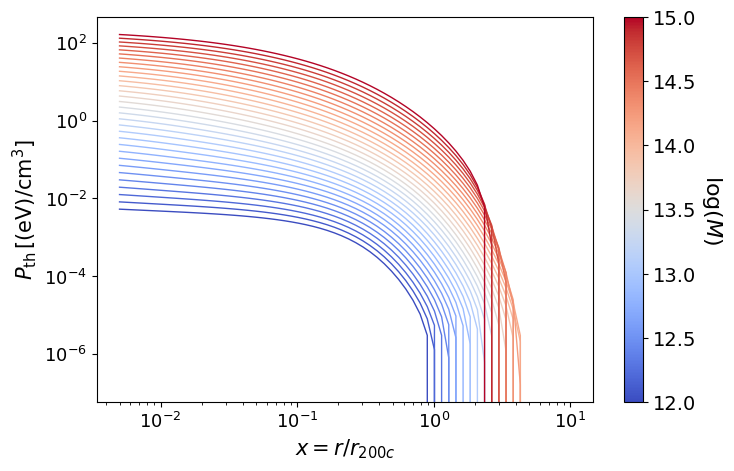

In [34]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(8,5))
Mc0_arr = np.log10(BCMP_test.M200c_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(Mc0_arr).min(), vmax=(Mc0_arr).max())

for jM in tqdm(range(len(Mc0_arr))):
    color = cmap(norm((Mc0_arr[jM])))
    # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[jM,0], BCMP_test.Pth_mat[:,4,0,jM], color=color, alpha=1.0,lw=1.0)
    pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,5,0,jM], color=color, alpha=1.0,lw=1.0)
    
    
# rho3 = Battaglia_12_16(M200c, zv, cosmo)
# pl.plot(r_array/r200c, ((r_array/r200c)**2)*rho_gas_KS, label = 'KS01', ls='--', color='k',lw=2.0)
# pl.plot(r_array/r200c, rho3.fb * ((r_array/r200c)**2)*rho_gas_B16, label = 'B16', ls=':', color='k',lw=2.0)

pl.xscale('log')
pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlabel(r'$x = r/r_{200c}$', fontsize=15)
# pl.ylabel(r'$x^2 \rho_{gas}$', fontsize=15)
pl.ylabel(r'$P_{\rm th} \, [({\rm eV})/{\rm cm}^3]$', fontsize=15)
# pl.title(r'$\theta_{\rm ej} = $' + str(theta_ej) + ',' + r'$M = $' + str(np.round(np.log10(M200c), 2)), fontsize=15)
# pl.legend(fontsize=14)

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\log(M)$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






/tmp/ipykernel_1350471/3625175284.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 32/32 [00:00<00:00, 126.42it/s]
/tmp/ipykernel_1350471/3625175284.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


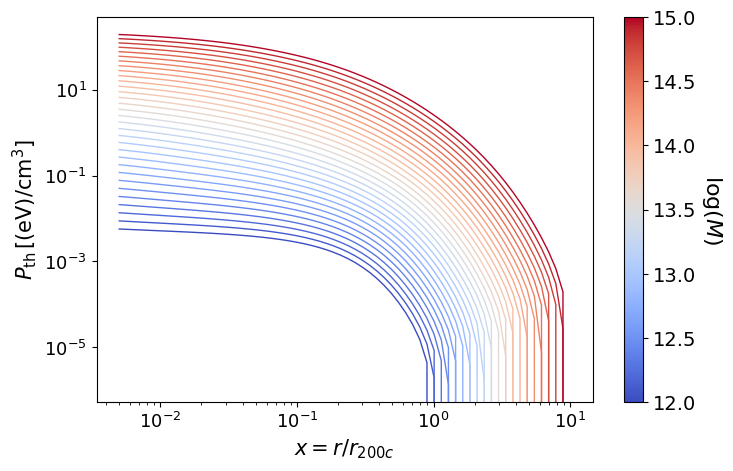

In [25]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(8,5))
Mc0_arr = np.log10(BCMP_test.M200c_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(Mc0_arr).min(), vmax=(Mc0_arr).max())

for jM in tqdm(range(len(Mc0_arr))):
    color = cmap(norm((Mc0_arr[jM])))
    # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[jM,0], BCMP_test.Pth_mat[:,4,0,jM], color=color, alpha=1.0,lw=1.0)
    pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,5,0,jM], color=color, alpha=1.0,lw=1.0)
    
    
# rho3 = Battaglia_12_16(M200c, zv, cosmo)
# pl.plot(r_array/r200c, ((r_array/r200c)**2)*rho_gas_KS, label = 'KS01', ls='--', color='k',lw=2.0)
# pl.plot(r_array/r200c, rho3.fb * ((r_array/r200c)**2)*rho_gas_B16, label = 'B16', ls=':', color='k',lw=2.0)

pl.xscale('log')
pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlabel(r'$x = r/r_{200c}$', fontsize=15)
# pl.ylabel(r'$x^2 \rho_{gas}$', fontsize=15)
pl.ylabel(r'$P_{\rm th} \, [({\rm eV})/{\rm cm}^3]$', fontsize=15)
# pl.title(r'$\theta_{\rm ej} = $' + str(theta_ej) + ',' + r'$M = $' + str(np.round(np.log10(M200c), 2)), fontsize=15)
# pl.legend(fontsize=14)

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\log(M)$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






/tmp/ipykernel_1350471/3684892926.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 32/32 [00:00<00:00, 129.22it/s]
/tmp/ipykernel_1350471/3684892926.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


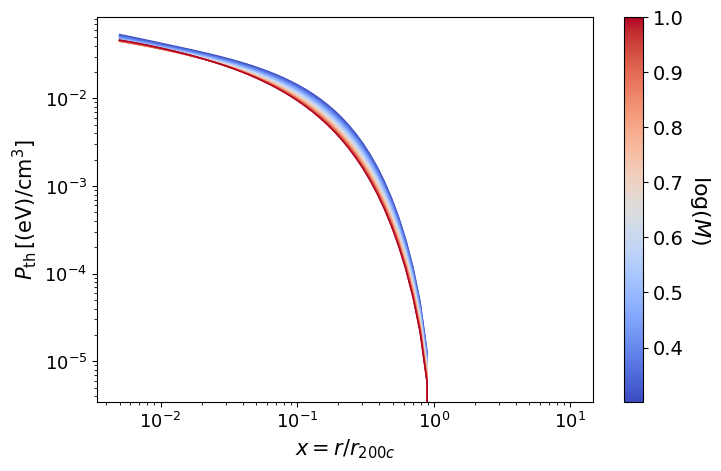

In [21]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(8,5))
Mc0_arr = np.log10(BCMP_test.conc_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(Mc0_arr).min(), vmax=(Mc0_arr).max())

for jM in tqdm(range(len(Mc0_arr))):
    color = cmap(norm((Mc0_arr[jM])))
    # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[jM,0], BCMP_test.Pth_mat[:,4,0,jM], color=color, alpha=1.0,lw=1.0)
    pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,jM,0,5], color=color, alpha=1.0,lw=1.0)
    
    
# rho3 = Battaglia_12_16(M200c, zv, cosmo)
# pl.plot(r_array/r200c, ((r_array/r200c)**2)*rho_gas_KS, label = 'KS01', ls='--', color='k',lw=2.0)
# pl.plot(r_array/r200c, rho3.fb * ((r_array/r200c)**2)*rho_gas_B16, label = 'B16', ls=':', color='k',lw=2.0)

pl.xscale('log')
pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlabel(r'$x = r/r_{200c}$', fontsize=15)
# pl.ylabel(r'$x^2 \rho_{gas}$', fontsize=15)
pl.ylabel(r'$P_{\rm th} \, [({\rm eV})/{\rm cm}^3]$', fontsize=15)
# pl.title(r'$\theta_{\rm ej} = $' + str(theta_ej) + ',' + r'$M = $' + str(np.round(np.log10(M200c), 2)), fontsize=15)
# pl.legend(fontsize=14)

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\log(M)$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






Text(0, 0.5, '$P_{\\rm th} \\, [({\\rm eV})/{\\rm cm}^3]$')

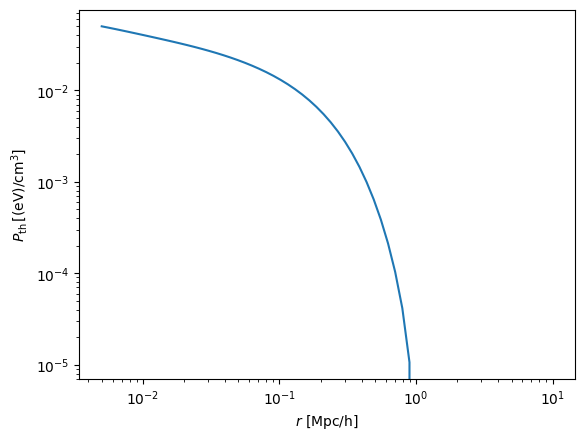

In [16]:
# plot the lines for different halo masses with a color map for each mass

pl.figure()
for ji in range(10):
    pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,4,0,5])
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r$ [Mpc/h]')
pl.ylabel(r'$P_{\rm th} \, [({\rm eV})/{\rm cm}^3]$')


In [10]:
from setup_power_spectra_jit import setup_power_BCMP

setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict, num_points_trapz_int=64)





2023-07-20 12:06:00.652040: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.91). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


CPU times: user 15.6 s, sys: 551 ms, total: 16.2 s
Wall time: 19.1 s


In [37]:
from get_power_spectra_jit import get_power_BCMP

# get_power_BCMP_test = get_power_BCMP(sim_params_dict, halo_params_dict, setup_power_BCMP_test, num_points_trapz_int=64)
get_power_BCMP_obj_test = get_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict,setup_power_BCMP_obj=setup_power_BCMP_test, verbose_time=True)



Time for setup_power_BCMP:  7.152557373046875e-07
Time for computing Wk_mat:  0.3037893772125244
Time for computing p_logc_Mz:  0.0033006668090820312
Time for computing Cl_kappa_y_1h_mat:  1.7703499794006348
Time for computing Cl_kappa_y_2h_mat:  0.10958313941955566
Time for computing Cl_kappa_kappa_1h_mat:  0.9578969478607178
Time for computing Cl_kappa_kappa_2h_mat:  0.11808991432189941
Time for computing Cl_kappa_kappa_nfw_1h_mat:  0.9075069427490234
Total time for computing all Cls:  4.203224182128906


In [38]:
# get_power_BCMP_obj_test.Cl_kappa_kappa_1h_mat.shape


In [39]:
# from get_corr_func import get_corrfunc_BCMP
from get_corr_func_jit import get_corrfunc_BCMP
get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, get_power_BCMP_obj=get_power_BCMP_obj_test, verbose_time=True)



Time for setup_power_BCMP:  1.430511474609375e-06
Time for gty Hankel transform:  0.24805188179016113
Time for xip Hankel transform:  0.24227261543273926
Time for xim Hankel transform:  0.23351120948791504


In [40]:
# get_corrfunc_BCMP_test.gty_1h_out_mat[:,3]


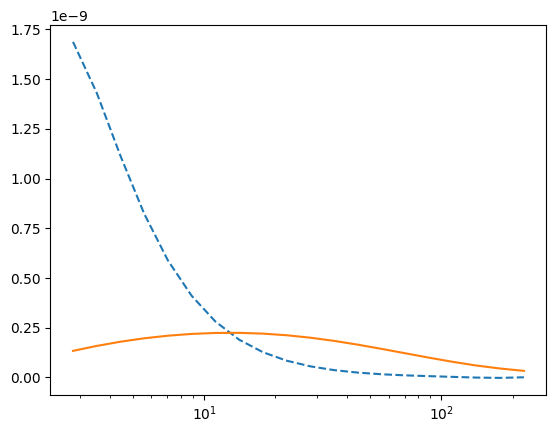

In [41]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.gty_1h_out_mat[:,3], ls='--')
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.gty_2h_out_mat[:,3], ls='-')
pl.xscale('log')
# pl.xlim(0.8,100)
# pl.ylim(0.0,2e-9)
# pl.yscale('log')




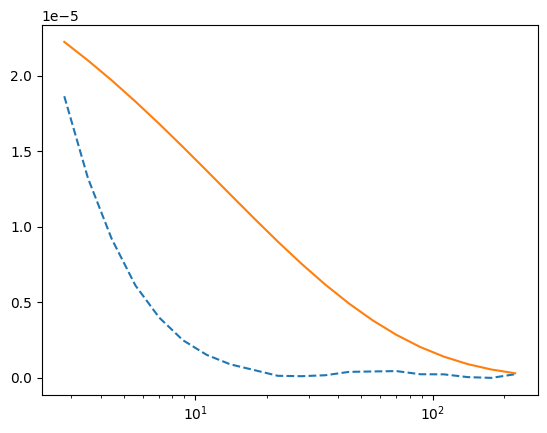

In [42]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.xip_1h_out_mat[:,3,3], ls='--')
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.xip_2h_out_mat[:,3,3], ls='-')
pl.xscale('log')
# pl.xlim(0.8,100)
# pl.ylim(0.0,2e-4)
# pl.yscale('log')




In [157]:
# get_corrfunc_BCMP_test.theta_out_arcmin

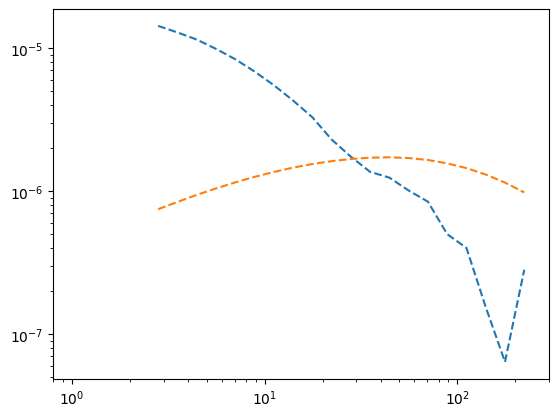

In [45]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.xim_1h_out_mat[:,3,3], ls='--')
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.xim_2h_out_mat[:,3,3], ls='--')
pl.xscale('log')
pl.xlim(0.8,300)
# pl.ylim(0.0,2e-5)
pl.yscale('log')




In [46]:
# check if all the elements are finite
# np.all(np.isfinite(setup_power_BCMP_test.uk_dmb)), np.all(np.isfinite(setup_power_BCMP_test.uk_nfw))


In [47]:
# check if all the elements are finite
# np.all(np.isfinite(setup_power_BCMP_test.uyl_mat))
# get_power_BCMP_obj_test.Cl_kappa_y_1h_mat


In [48]:
# pl.figure()
# pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_y_1h_mat[3,:], ls='--')
# pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_y_2h_mat[3,:], ls='-')
# pl.xlim(32, 8096)
# # pl.ylim(1e-19, 5e-13)
# # pl.plot(get_power_BCMP_test.ell_array, (get_power_BCMP_test.ell_array**3) * (get_power_BCMP_test.Cl_kappa_y_1h_mat[3,:] + get_power_BCMP_test.Cl_kappa_y_2h_mat[3,:]), ls='-') 
# pl.xscale('log')
# pl.yscale('log')




In [49]:
# pl.figure()
# pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_kappa_1h_mat[3,3,:] + get_power_BCMP_obj_test.Cl_kappa_kappa_2h_mat[3,3,:], ls='--')
# pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_kappa_nfw_1h_mat[3,3,:] + get_power_BCMP_obj_test.Cl_kappa_kappa_2h_mat[3,3,:], ls='-')
# pl.xlim(32, 8096)
# # pl.ylim(1e-19, 5e-13)
# # pl.plot(get_power_BCMP_test.ell_array, (get_power_BCMP_test.ell_array**3) * (get_power_BCMP_test.Cl_kappa_y_1h_mat[3,:] + get_power_BCMP_test.Cl_kappa_y_2h_mat[3,:]), ls='-') 
# pl.xscale('log')
# pl.yscale('log')




In [50]:
C = jnp.array(df_data['COVMAT'].data[400:,400:])
data_vec = jnp.array(df_data['compton_shear'].data['VALUE'])
gty_data_to_plot = data_vec[60:]
gty_sig_to_plot = jnp.sqrt(jnp.diag(C))[60:]



In [51]:
C = jnp.array(df_data['COVMAT'].data[:200,:200])
data_vec = jnp.array(df_data['xip'].data['VALUE'])
bin1, bin2 = df_data['xip'].data['BIN1'], df_data['xip'].data['BIN2']
indsel = np.where((bin1==4) & (bin2==4))[0]
xip_data_to_plot = data_vec[indsel]
xip_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]



In [52]:
C = jnp.array(df_data['COVMAT'].data[200:400,200:400])
data_vec = jnp.array(df_data['xim'].data['VALUE'])
bin1, bin2 = df_data['xim'].data['BIN1'], df_data['xim'].data['BIN2']
indsel = np.where((bin1==4) & (bin2==4))[0]
xim_data_to_plot = data_vec[indsel]
xim_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]



Text(0.5, 0, '$\\theta$ (arcmin)')

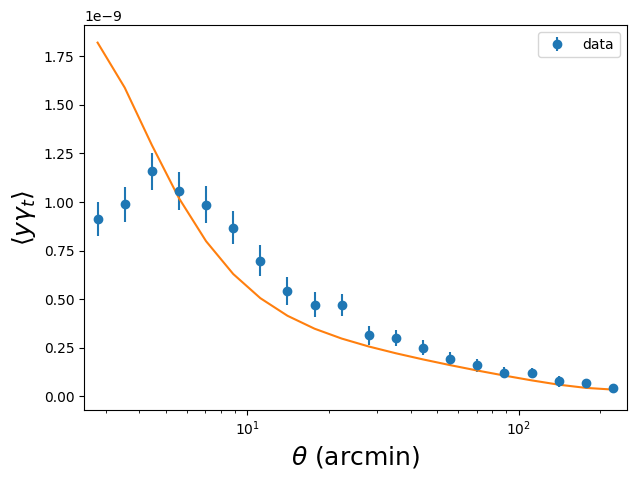

In [54]:
pl.figure(figsize=(7,5))
# pl.subplot(131)
pl.errorbar(analysis_dict['angles_data_array'], gty_data_to_plot, yerr=gty_sig_to_plot, fmt='o', label='data')
# for jt in range(len(theta_ej_all)):
pl.plot(analysis_dict['angles_data_array'], get_corrfunc_BCMP_test.gty_out_mat[:,3])
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
# pl.title(r'Variation of $\theta_{ej}$')
pl.ylabel(r'$\langle y \gamma_t \rangle$', size=18)
pl.xlabel(r'$\theta$ (arcmin)', size=18)


In [55]:
get_corrfunc_BCMP_test.xip_out_mat.shape

(20, 4, 4)

Text(0.5, 0, '$\\theta$ (arcmin)')

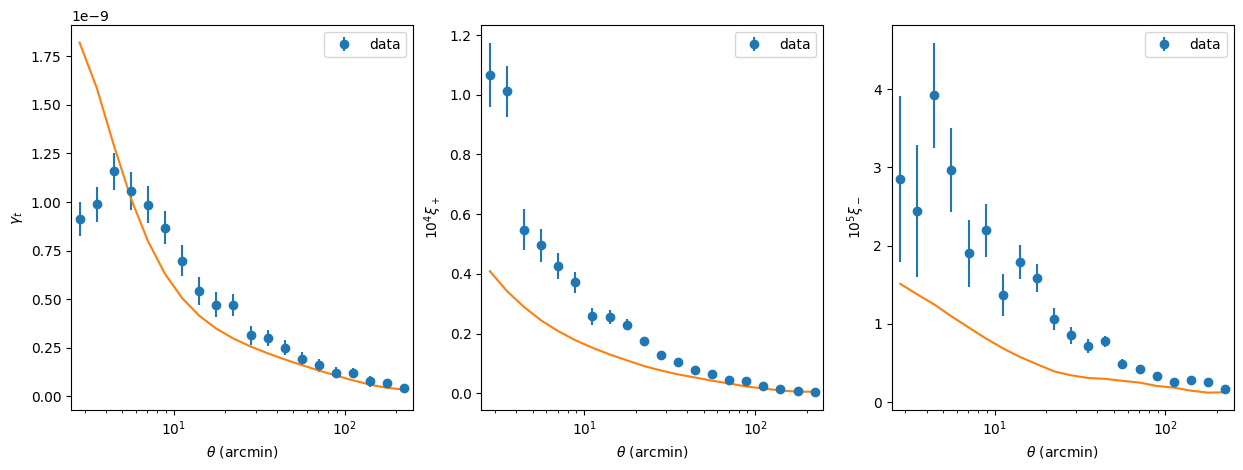

In [57]:
# make a three panel plot, plotting all the theta_ej curves for for gty_out_thetaej[:,3,:], xip_out_thetaej[:,3,3,:], xim_out_thetaej[:,3,3,:]
# draw theta_ej curves from a colormap

pl.figure(figsize=(15,5))
pl.subplot(131)
pl.errorbar(analysis_dict['angles_data_array'], gty_data_to_plot, yerr=gty_sig_to_plot, fmt='o', label='data')
pl.plot(analysis_dict['angles_data_array'], get_corrfunc_BCMP_test.gty_out_mat[:,3])
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
pl.ylabel(r'$\gamma_t$')
pl.xlabel(r'$\theta$ (arcmin)')
# pl.title('1-halo term')
pl.subplot(132)
pl.errorbar(analysis_dict['angles_data_array'], 1e4*xip_data_to_plot, yerr=1e4*xip_sig_to_plot, fmt='o', label='data')
pl.plot(analysis_dict['angles_data_array'], 1e4*get_corrfunc_BCMP_test.xip_out_mat[:,3,3])
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
pl.ylabel(r'$10^4 \xi_+$')
pl.xlabel(r'$\theta$ (arcmin)')
# pl.title('2-halo term')
pl.subplot(133)
pl.errorbar(analysis_dict['angles_data_array'], 1e5*xim_data_to_plot, yerr=1e5*xim_sig_to_plot, fmt='o', label='data')
pl.plot(analysis_dict['angles_data_array'], 1e5*get_corrfunc_BCMP_test.xim_out_mat[:,3,3])
pl.legend()
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
pl.ylabel(r'$10^5 \xi_-$')
pl.xlabel(r'$\theta$ (arcmin)')
# pl.title('2-halo term')






In [138]:
analysis_dict['angles_data_array']

Array([  2.80504614,   3.53134386,   4.44569853,   5.59680285,
         7.04595733,   8.87033473,  11.1670898 ,  14.05853313,
        17.69864461,  22.28127345,  28.05046136,  35.31343862,
        44.45698525,  55.96802846,  70.45957328,  88.70334731,
       111.67089804, 140.5853313 , 176.9864461 , 222.81273453],      dtype=float64)

In [52]:
# from colossus.lss import bias
# bM = bias.haloBias(setup_power_BCMP_test.M_array, 0.0, mdef='200c', model='tinker10')

# # dndm_jax.shape
# pl.figure()
# pl.plot(setup_power_BCMP_test.M_array, setup_power_BCMP_test.bias_Mz_mat[0,:])
# pl.plot(setup_power_BCMP_test.M_array, bM, ls='--')
# pl.xscale('log')
# # pl.yscale('log')





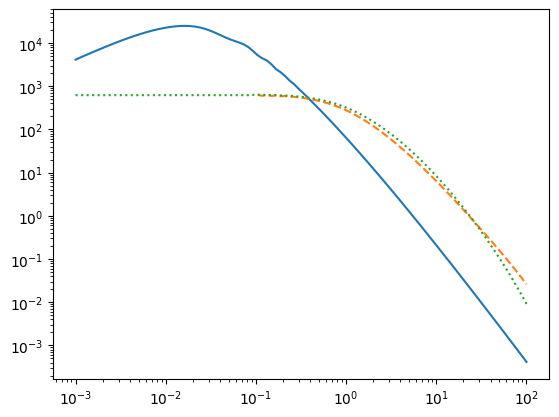

In [71]:
pl.figure()
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.plin_kz_mat[:,0])
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0], ls='--')
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0], ls=':')
pl.xscale('log')
pl.yscale('log')



(0.69, 1.5)

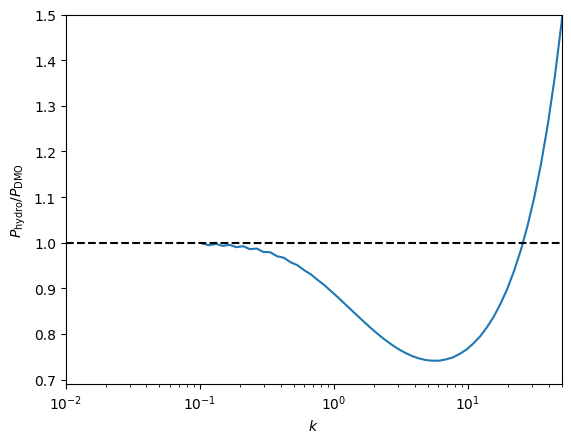

In [72]:
Pk_nfw = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0]
Pk_dmb = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0]
pl.figure()
pl.plot(setup_power_BCMP_test.kPk_array, (Pk_dmb)/Pk_nfw)
pl.xscale('log')
pl.axhline(1.0, color='k', ls='--')
pl.xlim(1e-2, 50)
pl.xlabel(r'$k$')
pl.ylabel(r'$P_{\rm hydro}/P_{\rm DMO}$')
pl.ylim(0.69,1.5)
# pl.yscale('log')




In [157]:
# setup_power_BCMP_test.Pmm_dmb_1h_mat.shape
# setup_power_BCMP_test.kPk_array
# setup_power_BCMP_test.uk_nfw_Pk[:,0,0,0]
# setup_power_BCMP_test.uk_dmb_Pk[:,0,0,0]
setup_power_BCMP_test.uk_dmb[:,0,0,0]
# (Pk_dmb)
# Pk_nfw

Array([-4.00917588e+01,  3.15555364e+01, -2.16192225e+01,  1.77459096e+01,
       -1.13110086e+01,  1.00646361e+01, -5.59863161e+00,  5.82615607e+00,
       -2.46205120e+00,  3.51198095e+00, -7.60692354e-01,  2.26615259e+00,
        1.47099797e-01,  1.60821567e+00,  6.20517368e-01,  1.26999674e+00,
        8.59309159e-01,  1.10289208e+00,  9.73576649e-01,  1.02530177e+00,
        1.02326095e+00,  9.92894412e-01,  1.04037961e+00,  9.81820950e-01,
        1.04144753e+00,  9.79233196e-01,  1.03430317e+00,  9.77881133e-01,
        1.02173048e+00,  9.72954473e-01,  1.00324800e+00,  9.60173240e-01,
        9.75929867e-01,  9.34720194e-01,  9.34983657e-01,  8.91115466e-01,
        8.74892490e-01,  8.24497564e-01,  7.91847864e-01,  7.33499282e-01,
        6.87197189e-01,  6.23330663e-01,  5.69473224e-01,  5.05703063e-01,
        4.51729914e-01,  3.93745303e-01,  3.45207093e-01,  2.96172389e-01,
        2.55588807e-01,  2.16272309e-01,  1.84131210e-01,  1.53955105e-01,
        1.29576529e-01,  

In [156]:
setup_power_BCMP_test.k

Array([8.54534660e-03, 1.00000000e-02, 1.17022755e-02, 1.36943251e-02,
       1.60254765e-02, 1.87534541e-02, 2.19458086e-02, 2.56815898e-02,
       3.00533038e-02, 3.51692040e-02, 4.11559714e-02, 4.81618515e-02,
       5.63603253e-02, 6.59544053e-02, 7.71816620e-02, 9.03201070e-02,
       1.05695077e-01, 1.23687291e-01, 1.44742275e-01, 1.69381398e-01,
       1.98214778e-01, 2.31956394e-01, 2.71441762e-01, 3.17648627e-01,
       3.71721174e-01, 4.34998358e-01, 5.09047061e-01, 5.95700894e-01,
       6.97105597e-01, 8.15772173e-01, 9.54639070e-01, 1.11714494e+00,
       1.30731378e+00, 1.52985460e+00, 1.79027800e+00, 2.09503263e+00,
       2.45166490e+00, 2.86900580e+00, 3.35738962e+00, 3.92890982e+00,
       4.59771851e+00, 5.38037685e+00, 6.29626521e+00, 7.36806300e+00,
       8.62231029e+00, 1.00900650e+01, 1.18076721e+01, 1.38176631e+01,
       1.61698100e+01, 1.89223571e+01, 2.21434636e+01, 2.59128911e+01,
       3.03239790e+01, 3.54859556e+01, 4.15266428e+01, 4.85956213e+01,
      

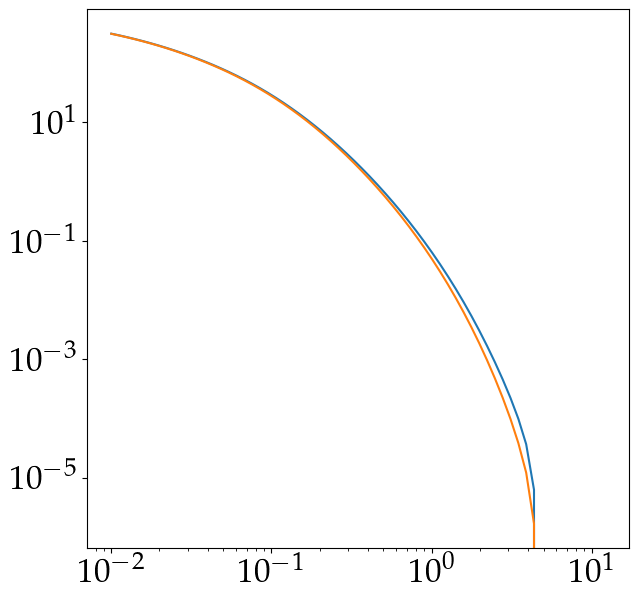

In [63]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,0,0,0])
pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




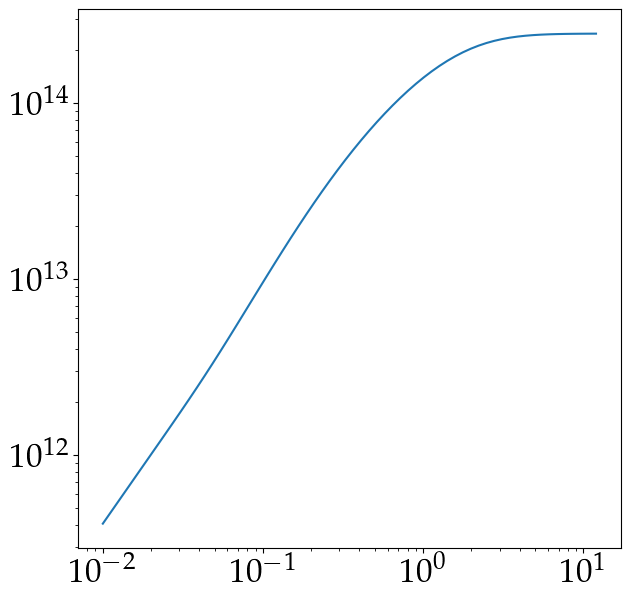

In [64]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Mdmb_mat[:,0,0,0])
# pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




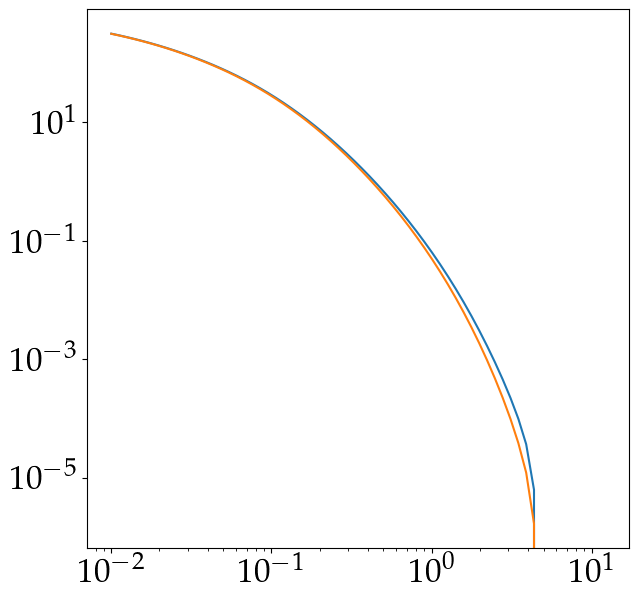

In [65]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,0,0,0])
pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




In [66]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_gas_normed, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_gas_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 222 ms, sys: 0 ns, total: 222 ms
Wall time: 171 ms


In [67]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_clm, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_clm_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 759 ms, sys: 16.4 ms, total: 775 ms
Wall time: 422 ms


In [68]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_cga, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_cga_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 153 ms


In [69]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_dmb, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_dmb_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 922 ms, sys: 36.1 ms, total: 959 ms
Wall time: 543 ms


In [94]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_nfw_normed, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_nfw_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 153 ms, sys: 4.86 ms, total: 158 ms
Wall time: 196 ms


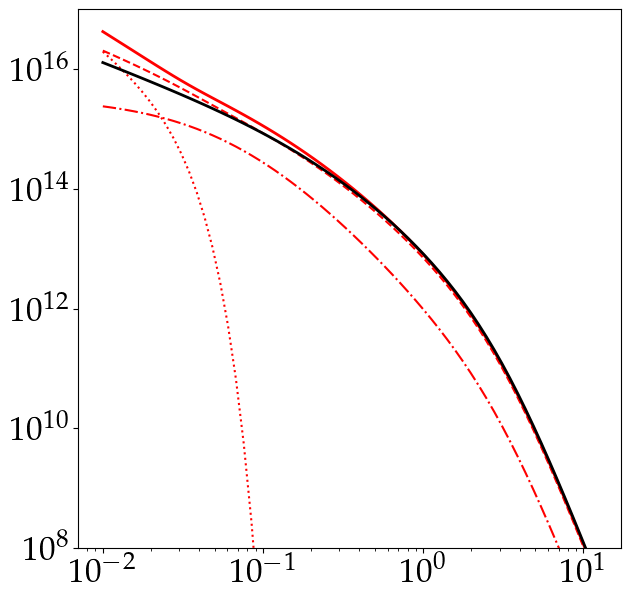

In [71]:
pl.figure()
pl.plot(BCMP_test.r_array, rho_gas_normed_mat[:,0,0,0], ls='-.', color='r')
pl.plot(BCMP_test.r_array, rho_clm_normed_mat[:,0,0,0], ls='--', color='r')
pl.plot(BCMP_test.r_array, rho_cga_normed_mat[:,0,0,0], ls=':', color='r')
pl.plot(BCMP_test.r_array, rho_dmb_normed_mat[:,0,0,0], ls='-', color='r', lw=2)
pl.plot(BCMP_test.r_array, rho_nfw_normed_mat[:,0,0,0], ls='-', color='k', lw=2)
pl.xscale('log')
pl.yscale('log')
pl.ylim(1e8, 1e17)
pl.show()






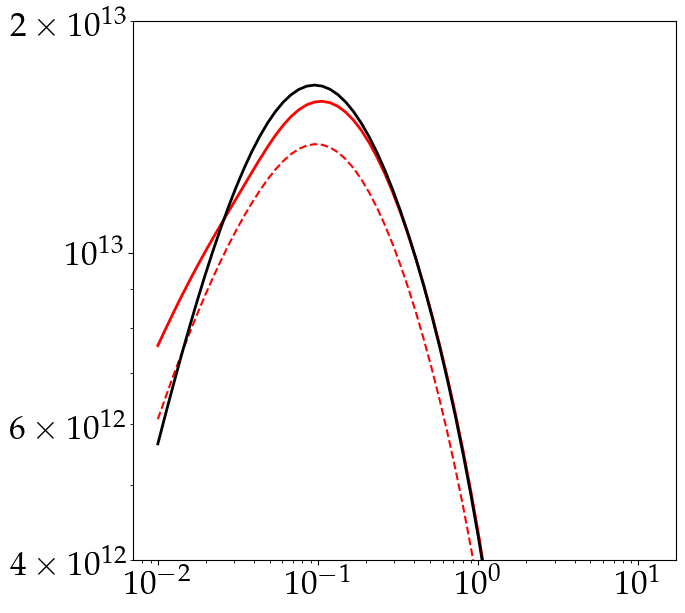

In [77]:
pl.figure()
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_gas_normed_mat[:,-5,0,0], ls='-.', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_clm_normed_mat[:,-5,0,0], ls='--', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_cga_normed_mat[:,-5,0,0], ls=':', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_dmb_normed_mat[:,-5,0,0], ls='-', color='r', lw=2)
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_nfw_normed_mat[:,-5,0,0], ls='-', color='k', lw=2)
pl.xscale('log')
pl.yscale('log')
pl.ylim(4e12,2e13)
# pl.ylim(1e8, 1e17)
pl.show()






In [91]:
# BCMP_test.conc_array[-5]
from mcfit import xi2P


In [104]:
Mtot_rep = jnp.repeat(BCMP_test.Mtot_mat[None, :, :, :], len(BCMP_test.r_array), axis=0)


In [103]:
BCMP_test.Mtot_mat.shape


(16, 64, 64)

In [109]:
k, P_nfw = xi2P(BCMP_test.r_array)(BCMP_test.rho_nfw_mat/Mnfw_rep, axis=0)



In [108]:
k, P_dmb = xi2P(BCMP_test.r_array)(BCMP_test.rho_dmb_mat/Mnfw_rep, axis=0)



In [128]:
window = jnp.ones(5) / 5
y_smooth = jnp.convolve(P_nfw[:,-5,0,0], window, mode='same')



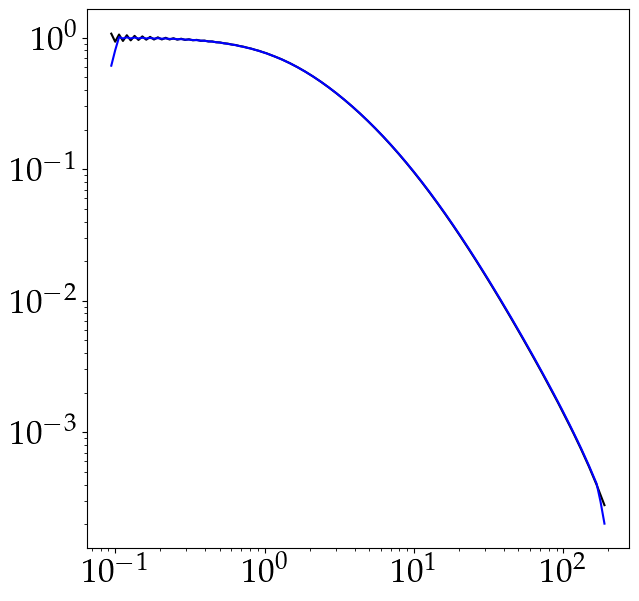

In [131]:
pl.figure()
indc = 3
window = jnp.ones(5) / 5
# pl.plot(k, (k**3) * P_nfw[:,indc,0,0], color='k')
# pl.plot(k, (k**3) * jnp.convolve(P_nfw[:,indc,0,0], window, mode='same'), color='b')
pl.plot(k, P_nfw[:,indc,0,0], color='k')
pl.plot(k, jnp.convolve(P_nfw[:,indc,0,0], window, mode='same'), color='b')

pl.xscale('log')
pl.yscale('log')




In [ ]:
from jax_cosmo.power import sigmasqr

